In [1]:
#Moving Average Convergence Divergence and Relative Strength Index

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

C:\Users\35385\AppData\Local\Temp\ipykernel_12244\2338742107.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval=interval, period=PERIOD)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,RSI,MACD_Strategy,RSI_Strategy,Full_Strat,Strategy,Asset_Returns,Strategy_Returns
15,629.869995,629.940002,629.450012,629.455017,293100,629.405219,629.325447,0.079771,0.043352,0.036419,84.016209,-1.0,-1.0,-2.0,-1,0.000651,-0.000651
16,629.960022,630.109924,629.880005,629.880005,269710,629.495870,629.388726,0.107143,0.056404,0.050739,84.824736,-1.0,-1.0,-2.0,-1,0.000794,-0.000794
17,629.970703,630.030029,629.919983,629.960022,157632,629.572721,629.445164,0.127557,0.070896,0.056661,84.891474,-1.0,-1.0,-2.0,-1,0.000811,-0.000811
18,630.104980,630.179993,629.919983,629.969971,200546,629.658182,629.507556,0.150626,0.087075,0.063551,86.021176,-1.0,-1.0,-2.0,-1,0.001025,-0.001024
19,630.090027,630.150024,630.059998,630.114990,200624,629.727058,629.561389,0.165669,0.102977,0.062692,84.301556,-1.0,-1.0,-2.0,-1,0.001001,-0.001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,636.789978,636.929993,636.625000,636.919983,915789,637.106543,637.225478,-0.118935,-0.061896,-0.057039,14.942126,1.0,1.0,2.0,1,0.011645,0.001140
1937,637.049988,637.090027,636.739990,636.789978,1011189,637.097842,637.212943,-0.115101,-0.072537,-0.042564,34.820991,1.0,1.0,2.0,1,0.012058,0.001549
1938,637.109985,637.119995,636.929993,637.054993,517938,637.099710,637.205589,-0.105879,-0.079205,-0.026673,41.284506,1.0,1.0,2.0,1,0.012153,0.001643
1939,636.960022,637.174988,636.960022,637.109985,957078,637.078220,637.188049,-0.109829,-0.085330,-0.024499,36.885287,1.0,0.0,1.0,0,0.011915,0.001643


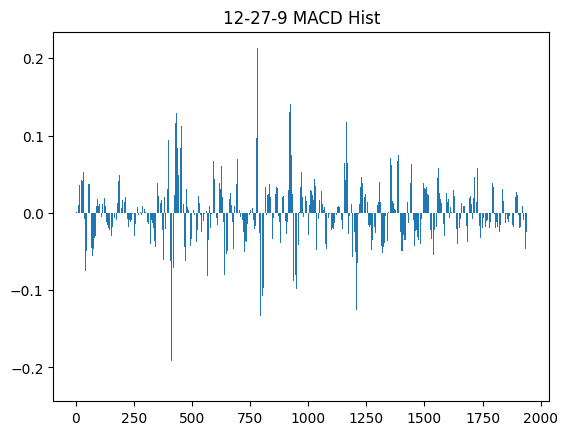

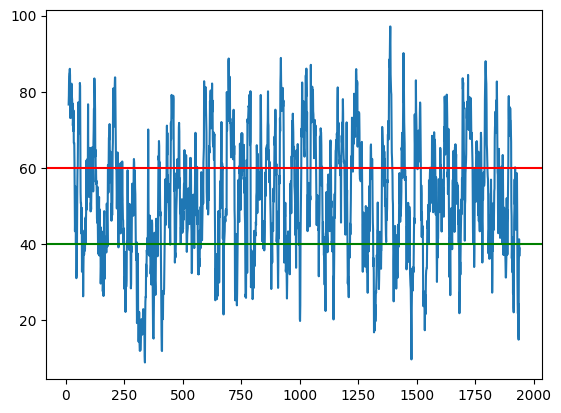

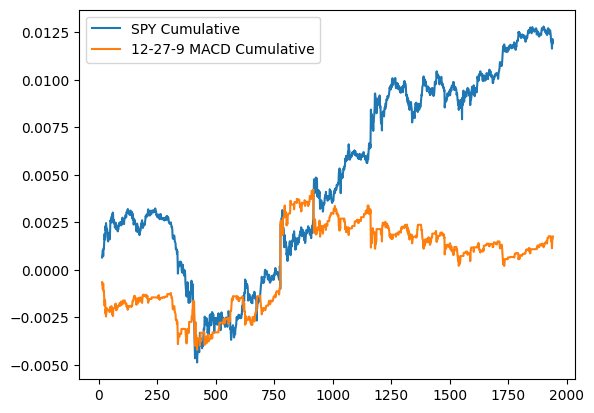

In [20]:

TICKER = 'SPY'
INTERVAL='1m'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

RSI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]


def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema '] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema '] = df['Close'].ewm(span=slow).mean()

    

    # macd line is diff between fast and slow (exp)
    df[f'MACD'] = df[f'{fast}_ema '] - df[f'{slow}_ema ']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    df['MACD_hist'] = df['MACD'] - df['Signal']


    plt.figure()
    plt.bar(x=range(len(df)),height=df['MACD_hist'])
    plt.title(f'{MACD_FAST}-{MACD_SLOW}-{MACD_SPAN} MACD Hist')

    return df



def add_RSI(df, length = RSI_LENGTH):
    
    #delta is change in price, diff shows diff between given row

    price_change = df['Close'].diff()

    #seperate gains and losses
    gain = price_change.where(price_change>0,0)
    loss = -price_change.where(price_change<0,0)

    #average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    #what % of each have the gains and losses been (RSI)
    rs = avg_gain/avg_loss
    rsi = 100 - (100/(1+rs))

    df['RSI'] = rsi

    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color = 'red') # # above red: overbought, potential short
    plt.axhline(OVERSOLD, color = 'green') # # below green: oversold, potential long

    return df.dropna()


#SUMMATION STRATEGY

#RSI has overbought denoted as -1, similar for 1, but also has a 0 (do nothing)
#MACD only has -1 and +1, doesn't have a 0
#We want to take long/shorts when our sum of both strats is +-2(when both strats overlap), else do nothing


def add_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):
    df.columns = df.columns.get_level_values(0)

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] < 0, 1,-1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI']>overbought,-1,
                              np.where(df['RSI']<oversold,1,0))
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)

    return df.dropna()


def add_full_strat(df):
    df['Full_Strat'] = df['MACD_Strategy'] + df['RSI_Strategy']
    
    #adjust for simplicity
    df['Strategy'] = np.where(df['Full_Strat'] == 2,1,
                              np.where(df['Full_Strat'] == -2,-1,0))
    return df



def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change()*df['Strategy']).cumprod() - 1
    
    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative',f'{MACD_FAST}-{MACD_SLOW}-{MACD_SPAN} MACD Cumulative' ])

    return df.dropna()

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_RSI(df)
    df = add_strategy(df)
    df = add_full_strat(df)
    df = test_strategy(df)

    return df

df = main()
df


In [8]:
df['Full_Strat'].value_counts()

Full_Strat
-1.0    403
 0.0    288
 1.0    271
-2.0     23
 2.0      1
Name: count, dtype: int64